In [9]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [10]:
FEATURES_LIST_FILE = "data/features"
RAW_DATA_CSV = "data/repro.csv"
BUILD_TAG = "BUILD?"
REPRODUCTIBLE_TAG = "REPRO?"

lines = None
with open(FEATURES_LIST_FILE, 'r') as stream:
    lines = map(lambda x: x.strip(), stream.readlines())

repro = pandas.read_csv(RAW_DATA_CSV)
repro_len = len(repro)
table = dict()

for elt in lines:
    table[elt] = [0 for _ in range(repro_len)]

table[BUILD_TAG] = list(repro["build?"])
table[REPRODUCTIBLE_TAG] = list(repro["reproducible?"])

for i in range(1, repro_len + 1):
    config = f"configs/{i:04d}_randconfig"
    with open(config, 'r') as stream:
        for line in stream:
            if line.startswith('#'):
                continue
            if line.startswith("CONFIG_"):
                name, value = line.strip().split('=')
                name = name[7:]
                table[name][i-1] = value

df = pandas.DataFrame.from_dict(table)

In [11]:
encoding_map = {
    'y': 1,
    'm': 2,
}

# Drop columns with datatype 'object'
df = df.replace(encoding_map)

constant_columns = df.columns[df.nunique() == 1]
df.drop(constant_columns, axis=1, inplace=True)


In [12]:
df

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZSTD_COMPRESS,ZSTD_DECOMPRESS,ZSWAP,ZSWAP_COMPRESSOR_DEFAULT,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT,ZSWAP_ZPOOL_DEFAULT_ZBUD,BUILD?,REPRO?
0,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True
1,1,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True
2,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,True,True
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True
4,0,2,0,0,0,0,0,0,0,0,...,1,1,1,"""lzo""",1,0,"""zbud""",1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True
1996,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True
1997,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,False
1998,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,True,True


In [13]:
df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)

In [14]:
# Drop the 'Unnamed: 0' column
# df.drop(columns=['Unnamed: 0'], inplace=True)

# Separate the target variable and features
X = df.drop(columns=['REPRO?'])
y = df['REPRO?']

# One-hot encode the features
# encoder = OneHotEncoder(drop='first', sparse=False)
# X_encoded = encoder.fit_transform(X)

# Apply the mapping to the dataframe, filling NaN with 0
X_encoded = X.replace(encoding_map).fillna(0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((1600, 12169), (400, 12169))

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy


1.0

In [16]:
from sklearn.tree import export_graphviz
import graphviz

ft_names = X_train.columns.tolist()

# Export the decision tree to DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ft_names, 
                           class_names=['Not Repro', 'Repro'], 
                           filled=True, rounded=True, 
                           special_characters=True)

# Render and save the visualization using graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_repro", format="png")


'decision_tree_repro.png'

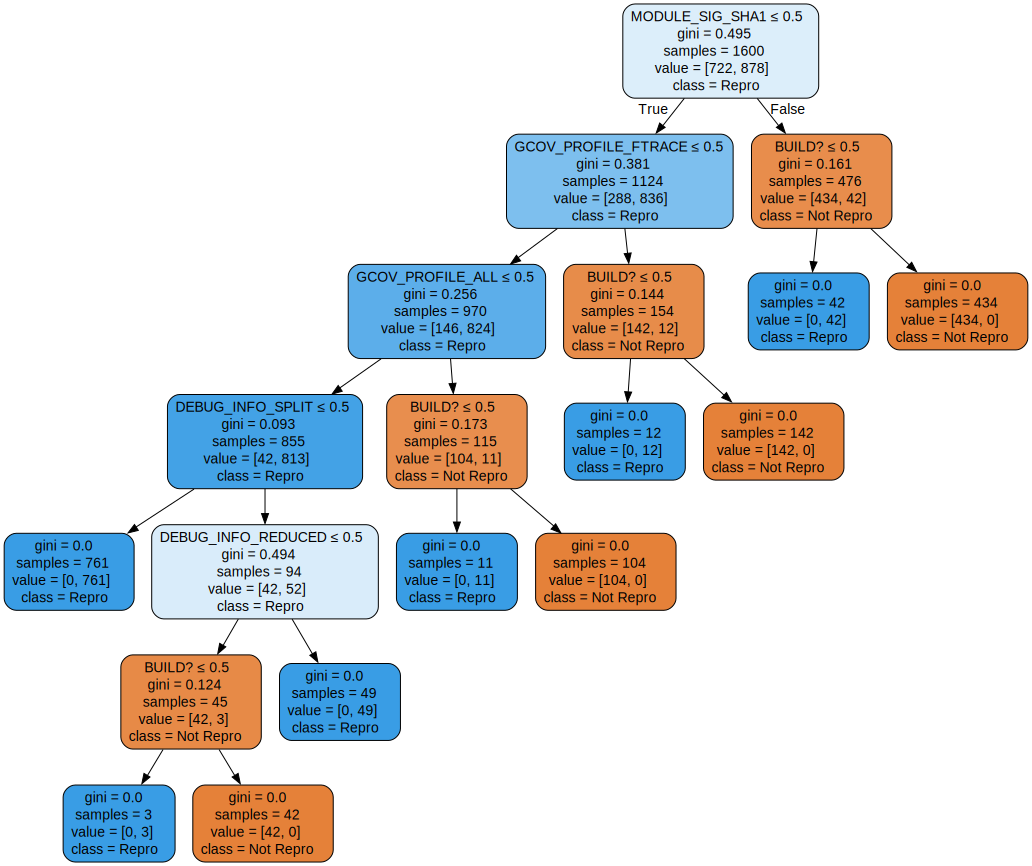

In [17]:
graph